<a href="https://colab.research.google.com/github/kevwee-lab/GA-Capstone-Food-Classifier/blob/main/Capstone_Modelling%2C_Evaluation_and_Conclusions.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Modelling 

Continuing from the previous notebook, we will select different categories of dessert/cake (10 classes) from the dataset. We will then proceed to build our own convolutional neural network (CNN) and fit our data onto the CNN. 

After this, we will proceed to fit our model on 2 pretrained models. We will be using VGG16 and EfficientNetB4.

In [ ]:
import os
import random
import numpy as np
import cv2
import h5py
import json
import pandas as pd
import matplotlib.image as img
import matplotlib.pyplot as plt
%matplotlib inline

import tensorflow as tf
import keras
from tensorflow.keras import optimizers
from tensorflow.keras.applications import InceptionV3
from tensorflow.keras.applications.vgg16 import VGG16
from tensorflow.python.keras.preprocessing import image
from tensorflow.python.keras.preprocessing.image import ImageDataGenerator
from tensorflow.python.keras.models import Model,load_model,Sequential
from tensorflow.python.keras.layers import Dense, GlobalAveragePooling2D, Dropout,Flatten, Input, Conv2D, MaxPool2D, Dropout, Flatten
from tensorflow.python.keras import backend as K
from tensorflow.keras.callbacks import ModelCheckpoint, Callback, EarlyStopping
from tensorflow.keras.layers.experimental.preprocessing import Rescaling

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [ ]:
#change working directory
os.chdir('/content/gdrive/MyDrive/capstone_project/datasets/')

In [ ]:
#loading food dataframe

food_df = pd.read_csv('food_df.csv')

In [ ]:
food_df.head()

path category
0  /content/gdrive/MyDrive/capstone_project/datas...  edamame
1  /content/gdrive/MyDrive/capstone_project/datas...  edamame
2  /content/gdrive/MyDrive/capstone_project/datas...  edamame
3  /content/gdrive/MyDrive/capstone_project/datas...  edamame
4  /content/gdrive/MyDrive/capstone_project/datas...  edamame

In [ ]:
food_df.shape

(101000, 2)

In [ ]:
food_df.isnull().sum()

path        0
category    0
dtype: int64

## Train Test Split
Here we will create a train test split manually, splitting the data into 80% train, 20% test. We will also separate the data into train and validation dataframes, and shuffle the data.

In [ ]:
#create a list of categories/classes that are similar
desserts = ['baklava', 'bread pudding', 'carrot cake', 'cheesecake', 'chocolate cake',
            'creme brulee', 'cup cakes', 'red velvet cake', 'strawberry shortcake', 'tiramisu']


In [ ]:
#create 10 different dataframes for the different categories

df1 = food_df[food_df['category'] == 'baklava'] 
df2 = food_df[food_df['category'] == 'bread pudding']
df3 = food_df[food_df['category'] == 'carrot cake']
df4 = food_df[food_df['category'] == 'cheesecake']
df5 = food_df[food_df['category'] == 'chocolate cake']
df6 = food_df[food_df['category'] == 'creme brulee']
df7 = food_df[food_df['category'] == 'cup cakes']
df8 = food_df[food_df['category'] == 'red velvet cake']
df9 = food_df[food_df['category'] == 'strawberry shortcake']
df10 = food_df[food_df['category'] == 'tiramisu']


In [ ]:
# Add Class columns
df1['class'] = pd.Series([0 for x in range(len(df1.index))], index=df1.index)
df2['class'] = pd.Series([1 for x in range(len(df2.index))], index=df2.index)
df3['class'] = pd.Series([2 for x in range(len(df3.index))], index=df3.index)
df4['class'] = pd.Series([3 for x in range(len(df4.index))], index=df4.index)
df5['class'] = pd.Series([4 for x in range(len(df5.index))], index=df5.index)
df6['class'] = pd.Series([5 for x in range(len(df6.index))], index=df6.index)
df7['class'] = pd.Series([6 for x in range(len(df7.index))], index=df7.index)
df8['class'] = pd.Series([7 for x in range(len(df8.index))], index=df8.index)
df9['class'] = pd.Series([8 for x in range(len(df9.index))], index=df9.index)
df10['class'] = pd.Series([9 for x in range(len(df10.index))], index=df10.index)

In [ ]:
# Split into train and validation sets
train_set_percentage = 0.8


train_df = df1[:int(len(df1)*train_set_percentage)]
val_df = df1[int(len(df1)*train_set_percentage):]

train_df2 = df2[:int(len(df2)*train_set_percentage)]
val_df2 = df2[int(len(df2)*train_set_percentage):]

train_df3 = df3[:int(len(df3)*train_set_percentage)]
val_df3 = df3[int(len(df3)*train_set_percentage):]

train_df4 = df4[:int(len(df4)*train_set_percentage)]
val_df4 = df4[int(len(df4)*train_set_percentage):]

train_df5 = df5[:int(len(df5)*train_set_percentage)]
val_df5 = df5[int(len(df5)*train_set_percentage):]

train_df6 = df6[:int(len(df6)*train_set_percentage)]
val_df6 = df6[int(len(df6)*train_set_percentage):]

train_df7 = df7[:int(len(df7)*train_set_percentage)]
val_df7 = df7[int(len(df7)*train_set_percentage):]

train_df8 = df8[:int(len(df8)*train_set_percentage)]
val_df8 = df8[int(len(df8)*train_set_percentage):]

train_df9 = df9[:int(len(df9)*train_set_percentage)]
val_df9 = df9[int(len(df9)*train_set_percentage):]

train_df10 = df10[:int(len(df10)*train_set_percentage)]
val_df10 = df10[int(len(df10)*train_set_percentage):]


#concatenate the dataframes 
df_new_train = pd.concat([train_df, train_df2, train_df3, train_df4, 
                          train_df5, train_df6, train_df7, train_df8, train_df9, train_df10])
df_new_val = pd.concat([val_df, val_df2, val_df3, val_df4, val_df5, 
                        val_df6, val_df7, val_df8, val_df9, val_df10])

df_new_train = df_new_train.drop(columns='category')
df_new_val = df_new_val.drop(columns='category')


#shuffle
df_train = df_new_train.sample(frac=1).reset_index(drop=True)
df_val = df_new_val.sample(frac=1).reset_index(drop=True)

In [ ]:
df_train.shape

(8000, 2)

In [ ]:
df_val.shape

(2000, 2)

In [ ]:
df_train['class'].unique()

array([6, 5, 9, 8, 0, 3, 2, 7, 4, 1])

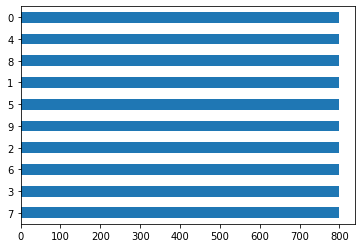

In [ ]:
#visualising the 5 classes to see if there is any imbalance
df_train['class'].value_counts().plot(kind='barh') #no imbalanced classes

In [ ]:
#saving train test dataframes into csv
df_train.to_csv('train_10.csv')
df_val.to_csv('test_10.csv')

## Data preprocessing and pipeline

At this step, we convert the training and validation dataframes into a list, and use a function to decode, resize the image and one hot encode our labels. After which we convert the images and labels into tensors, and use the tensorflow dataset method to create a dataset with the processed images and labels.

In [ ]:
df_train = pd.read_csv('train_10.csv')
df_val = pd.read_csv('test_10.csv')

In [ ]:
# convert the dataframe into 2 lists to use for filename and labels
train_filenames_list = df_train['path'].tolist()
train_labels_list = df_train['class'].astype('int32').tolist()

# convert the dataframe into 2 lists to use for filename and labels
val_filenames_list = df_val['path'].tolist()
val_labels_list = df_val['class'].astype('int32').tolist()

#number of classes
num_classes = 10

In [ ]:
# Set up some Hyperparameters
batch_size = 32
lr = 0.001
img_rows, img_cols = 224, 224

In [ ]:
#function to resize image and hot encode labels
def _parse_function(filename, label):
  image_string = tf.io.read_file(filename)
  image_decoded = tf.image.decode_jpeg(image_string,channels=3)
  image_resized = tf.image.resize(image_decoded, [img_rows, img_cols])
  #image_rescaled = image_resized / 255
  label = tf.one_hot(label, num_classes)
  return image_resized, label

In [ ]:
# creating a constant tensor of filenames from list
filenames = tf.constant(train_filenames_list)

# creating a constant tensor of labels from a list
labels = tf.constant(train_labels_list)

# creating constant tensors from validation data lists
val_filenames = tf.constant(val_filenames_list)
val_labels = tf.constant(val_labels_list)

In [ ]:
# Assembling data pipeline 
train_dataset = tf.data.Dataset.from_tensor_slices((filenames, labels))
train_dataset = train_dataset.map(_parse_function)
train_dataset = train_dataset.batch(32)

In [ ]:
valid_dataset = tf.data.Dataset.from_tensor_slices((val_filenames, val_labels))
valid_dataset = valid_dataset.map(_parse_function)
valid_dataset = valid_dataset.batch(32)

In our earlier experimentation with VGG16, we repeated the dataset 100 times. This would inflate our dataset and cause a large increase in step size to 25,000 for training, therefore we controlled the step sizes earlier. 

We will not be doing so for the actual modelling as we have increased our classes to 10 class from 5, bringing our total training images to 8000 and validation images to 2000.

In [ ]:
#for images, labels in train_dataset.take(1):  # only take first element of dataset
#    numpy_images = images.numpy() #convert images from tensors to numpy
#    numpy_labels = labels.numpy() #convert labels from tensors to numpy

#numpy_images

In [ ]:
# we take the first element in the dataset to print one of the labels 

for images, labels in train_dataset.take(1):
    print(labels[1])
    print(np.argmax(labels[1]))
    print(desserts[np.argmax(labels[1])])

tf.Tensor([0. 0. 0. 0. 0. 1. 0. 0. 0. 0.], shape=(10,), dtype=float32)
5
creme brulee


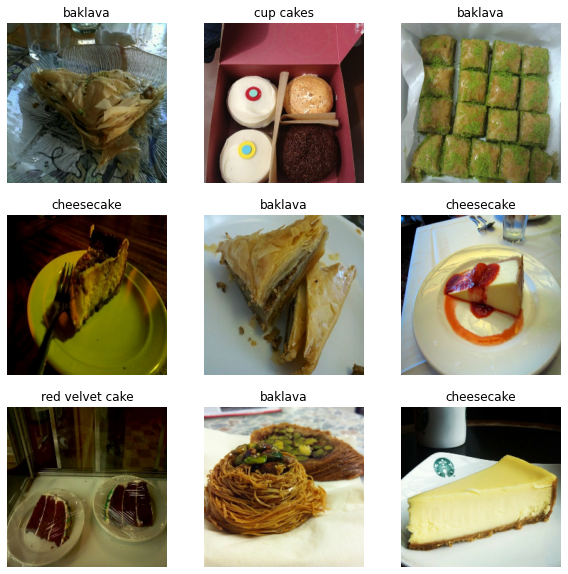

In [ ]:
#randomly view images first element of dataset
plt.figure(figsize=(10, 10))
for images, labels in train_dataset.take(1):
    for i, j in zip(range(9), random.sample(range(32), 9)):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[j].numpy().astype("uint8"))
        plt.title(desserts[np.argmax(labels[j])])
        plt.axis("off")

## Modelling

### Building CNN

We will be building our own convolutional neural network to train our dataset.

In [ ]:


model = Sequential([
  Rescaling(1./255, input_shape=(img_rows, img_cols, 3)),
  Conv2D(32, 3, activation='relu'),
  Conv2D(32, 3, activation='relu'),
  MaxPool2D(2, 2),
  Conv2D(64, 3, activation='relu'),
  Conv2D(64, 3, activation='relu'),
  MaxPool2D(2, 2),
  Conv2D(128, 3, activation='relu'),
  Conv2D(128, 3, activation='relu'),
  MaxPool2D(2, 2),
  GlobalAveragePooling2D(),
  Dense(64, activation='relu'),
  Dropout(0.25),
  Dense(32, activation='relu'),
  Dropout(0.25),
  Dense(num_classes, activation='softmax')
])



model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
rescaling (Rescaling)        (None, 224, 224, 3)       0         
_________________________________________________________________
conv2d (Conv2D)              (None, 222, 222, 32)      896       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 220, 220, 32)      9248      
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 110, 110, 32)      0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 108, 108, 64)      18496     
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 106, 106, 64)      36928     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 53, 53, 64)        0

In [ ]:
_# creates the optimizer using a tensorFlow optimizer with lr setting the Learning Rate

# tf.keras optimizer
opt = optimizers.Adam(lr)

# compile the model 
model.compile(optimizer= opt, loss='categorical_crossentropy',metrics=['acc'])

In [ ]:
#create model checkpoint to save our model and weights

checkpoint = ModelCheckpoint('./checkpoints/custom_cnn_weights_{epoch:02d}_{val_acc:.2f}.hdf5', verbose=1, 
                             save_best_only=True, mode='auto')

In [ ]:
# early stopping if no improvement in val loss after 5 epochs

early_stopping = EarlyStopping(
    monitor = 'val_loss',
    patience=5,
    min_delta=0.001,
    restore_best_weights=True)

We are optimizing for validation accuracy, but we must take into account validation loss as we also want a model that can generalise well on unseen data.

In [ ]:
#define the train, val steps and epochs

#train_steps = 250
#val_steps = 100
epochs = 20

In [ ]:
#optimise cpu/gpu allocation

AUTOTUNE = tf.data.experimental.AUTOTUNE

train_dataset = train_dataset.prefetch(buffer_size=AUTOTUNE)
valid_dataset = valid_dataset.prefetch(buffer_size=AUTOTUNE)



In [ ]:
# Train the model 
history = model.fit(train_dataset, 
                   batch_size = batch_size,
                   epochs = epochs,
                   #steps_per_epoch = train_steps,
                   validation_data = valid_dataset,
                   #validation_steps = val_steps,
                   callbacks=[early_stopping, checkpoint])

Epoch 1/20
250/250 [==============================] - 3233s 13s/step - loss: 2.3046 - acc: 0.0978 - val_loss: 2.3026 - val_acc: 0.1000

Epoch 00001: val_loss improved from inf to 2.30261, saving model to ./checkpoints/custom_cnn_weights_01_0.10.hdf5
Epoch 2/20
250/250 [==============================] - 38s 151ms/step - loss: 2.3013 - acc: 0.1024 - val_loss: 2.2690 - val_acc: 0.1685

Epoch 00002: val_loss improved from 2.30261 to 2.26898, saving model to ./checkpoints/custom_cnn_weights_02_0.17.hdf5
Epoch 3/20
250/250 [==============================] - 38s 153ms/step - loss: 2.2299 - acc: 0.1494 - val_loss: 2.1505 - val_acc: 0.2105

Epoch 00003: val_loss improved from 2.26898 to 2.15054, saving model to ./checkpoints/custom_cnn_weights_03_0.21.hdf5
Epoch 4/20
250/250 [==============================] - 38s 151ms/step - loss: 2.1479 - acc: 0.2170 - val_loss: 2.0647 - val_acc: 0.2410

Epoch 00004: val_loss improved from 2.15054 to 2.06469, saving model to ./checkpoints/custom_cnn_weights_0

### Custom CNN Model Evaluation

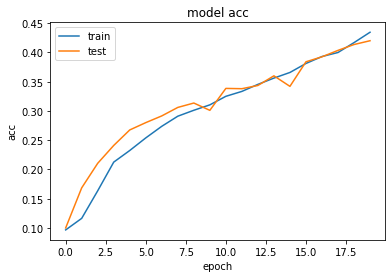

In [ ]:
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('model acc')
plt.ylabel('acc')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

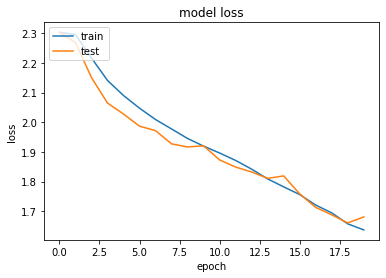

In [ ]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [ ]:
#evaluating model accuracy
metrics = model.evaluate(valid_dataset)
print("model accuracy:",metrics[1])

63/63 [==============================] - 7s 117ms/step - loss: 1.6811 - acc: 0.4200
model accuracy: 0.41999998688697815


There does not seem to be any severe overfitting for the data. However, the CNN model we built does not seem to perform as well in terms of accuracy, compared to the 5-class base model (VGG16) we fitted earlier. We will tune our model by using keras tuner to find the best model before proceeding to use transfer learning and fit our data on pretrained models.


## Tuning CNN to optimise accuracy

We use RandomSearch from keras tuners to help us improve the accuracy scores. RandomSearch allows us to find the best parameters for the different layers of our model. In this instance, we will try to find the best parameters for our dense layers, learning rate and epochs. We will then fit our data on the tuned model and best epoch.

In [ ]:
pip install -U keras-tuner

     |████████████████████████████████| 71kB 5.4MB/s 
  Created wheel for keras-tuner: filename=keras_tuner-1.0.2-cp37-none-any.whl size=78938 sha256=a2030e08e3ab12195fba4ae0a2f44e32bdfcb1428bdbf35b1ac9bd5681b1fcd7
  Stored in directory: /root/.cache/pip/wheels/bb/a1/8a/7c3de0efb3707a1701b36ebbfdbc4e67aedf6d4943a1f463d6
  Created wheel for terminaltables: filename=terminaltables-3.1.0-cp37-none-any.whl size=15356 sha256=b05b47e1dcdfe474285ca820f57c2708ed87a29a44dc1ea5223620a53edd815d
  Stored in directory: /root/.cache/pip/wheels/30/6b/50/6c75775b681fb36cdfac7f19799888ef9d8813aff9e379663e
Successfully built keras-tuner terminaltables


In [ ]:
from kerastuner.tuners import RandomSearch

def build_model(hp):
  model= keras.Sequential([
  Rescaling(1./255, input_shape=(img_rows, img_cols, 3)),
  Conv2D(32, 3, activation='relu'),
  Conv2D(32, 3, activation='relu'),
  MaxPool2D(2, 2),
  Conv2D(64, 3, activation='relu'),
  Conv2D(64, 3, activation='relu'),
  MaxPool2D(2, 2),
  Conv2D(128, 3, activation='relu'),
  Conv2D(128, 3, activation='relu'),
  MaxPool2D(2, 2),
  Dropout(0.25),
  GlobalAveragePooling2D(),
  Dense(hp.Choice("Dense layer", [32, 64, 128, 256]), activation='relu'),
  Dropout(0.25),
  Dense(hp.Choice("Dense layer", [32, 64, 128, 256]), activation='relu'),
  Dropout(0.25),
  Dense(num_classes, activation='softmax')
])
  
  hp_learning_rate = hp.Choice('learning_rate', values=[1e-2, 1e-3, 1e-4])

  model.compile(optimizer= keras.optimizers.Adam(learning_rate=hp_learning_rate), 
                loss='categorical_crossentropy',
                metrics=['acc'])
  return model


tuner = RandomSearch(
    build_model,
    objective='val_acc',
    max_trials = 5,
    directory = './content/gdrive/MyDrive/capstone_project/datasets/'
)

tuner.search(train_dataset, validation_data=valid_dataset, epochs=10,batch_size=32)


Trial 5 Complete [00h 06m 19s]
val_acc: 0.3215000033378601

Best val_acc So Far: 0.3734999895095825
Total elapsed time: 00h 32m 12s
INFO:tensorflow:Oracle triggered exit


In [ ]:
# Get the optimal hyperparameters
best_hps=tuner.get_best_hyperparameters(num_trials=1)[0]

In [ ]:
#fit and train best model and find optimal epoch
model = tuner.hypermodel.build(best_hps)
history = model.fit(train_dataset, validation_data=valid_dataset, epochs=20)

val_acc_per_epoch = history.history['val_acc']
best_epoch = val_acc_per_epoch.index(max(val_acc_per_epoch)) + 1
print('Best epoch: %d' % (best_epoch,))

Epoch 1/20
250/250 [==============================] - 38s 149ms/step - loss: 2.2914 - acc: 0.1005 - val_loss: 2.1821 - val_acc: 0.1595
Epoch 2/20
250/250 [==============================] - 37s 148ms/step - loss: 2.1614 - acc: 0.1935 - val_loss: 2.0789 - val_acc: 0.2485
Epoch 3/20
250/250 [==============================] - 36s 145ms/step - loss: 2.0837 - acc: 0.2391 - val_loss: 2.0394 - val_acc: 0.2445
Epoch 4/20
250/250 [==============================] - 37s 146ms/step - loss: 2.0370 - acc: 0.2540 - val_loss: 2.0276 - val_acc: 0.2600
Epoch 5/20
250/250 [==============================] - 37s 148ms/step - loss: 2.0137 - acc: 0.2702 - val_loss: 1.9512 - val_acc: 0.3005
Epoch 6/20
250/250 [==============================] - 36s 145ms/step - loss: 1.9511 - acc: 0.3068 - val_loss: 1.9748 - val_acc: 0.2810
Epoch 7/20
250/250 [==============================] - 36s 146ms/step - loss: 1.9272 - acc: 0.3059 - val_loss: 1.9312 - val_acc: 0.3095
Epoch 8/20
250/250 [==============================] - 3

In [ ]:
#refit and train with optimal epoch

hypermodel = tuner.hypermodel.build(best_hps)
history = hypermodel.fit(train_dataset, validation_data=valid_dataset, epochs=best_epoch)

Epoch 1/19
250/250 [==============================] - 36s 140ms/step - loss: 2.2791 - acc: 0.1214 - val_loss: 2.1377 - val_acc: 0.2130
Epoch 2/19
250/250 [==============================] - 36s 143ms/step - loss: 2.1493 - acc: 0.1938 - val_loss: 2.0672 - val_acc: 0.2450
Epoch 3/19
250/250 [==============================] - 35s 139ms/step - loss: 2.0763 - acc: 0.2256 - val_loss: 2.0349 - val_acc: 0.2515
Epoch 4/19
250/250 [==============================] - 35s 140ms/step - loss: 2.0410 - acc: 0.2472 - val_loss: 1.9940 - val_acc: 0.2790
Epoch 5/19
250/250 [==============================] - 35s 142ms/step - loss: 1.9987 - acc: 0.2721 - val_loss: 1.9779 - val_acc: 0.2755
Epoch 6/19
250/250 [==============================] - 36s 142ms/step - loss: 1.9653 - acc: 0.2935 - val_loss: 1.9471 - val_acc: 0.2950
Epoch 7/19
250/250 [==============================] - 35s 140ms/step - loss: 1.9337 - acc: 0.3043 - val_loss: 1.8783 - val_acc: 0.3285
Epoch 8/19
250/250 [==============================] - 3

In [ ]:
hypermodel.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
rescaling (Rescaling)        (None, 224, 224, 3)       0         
_________________________________________________________________
conv2d (Conv2D)              (None, 222, 222, 32)      896       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 220, 220, 32)      9248      
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 110, 110, 32)      0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 108, 108, 64)      18496     
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 106, 106, 64)      36928     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 53, 53, 64)        0

In [ ]:
metrics = hypermodel.evaluate(valid_dataset)
print("model accuracy:",metrics[1])

63/63 [==============================] - 7s 108ms/step - loss: 1.4568 - acc: 0.4975
model accuracy: 0.4975000023841858


After the tuning we managed to increase the accuracy to almost 50%, but this is still not ideal. We will proceed to explore using transfer learning to fit our data.

## Training VGG16

Earlier in our previous notebook on EDA and transfer learning, we used VGG16 and it gave us high accuracy for our japanese food classifier. We will now proceed to train it with 10 classes.

We will proceed to build on the VGG16 architecture as follows:
1. Remove final dense/prediction layers.
2. Create global average pooling, dense, dropout and prediction layers.
3. Freeze all convolutional VGG layers.

We freeze the convolutional layers as we do not want to further modify their weights. This also helps us reduce computational time required to train our model as the backpropagation is reduced. 

In [ ]:
# create the base pre-trained model
base_vgg = VGG16(weights='imagenet', 
                 include_top=False, 
                 input_shape=(224, 224, 3)) #remove the last prediction layer by declaring include_top=False

58892288/58889256 [==============================] - 0s 0us/step


In [ ]:
# freeze all convolutional VGG16 layers. 
#Freezing reduces training time as the backward passes go down in number.

for layer in base_vgg.layers:
    layer.trainable = False

In [ ]:
x = base_vgg.output

#Adaptive Pooling
x = GlobalAveragePooling2D()(x) 
#Dense Layer
x = Dense(512, activation='relu')(x)
#Dropout 
x = Dropout(0.3)(x)

# we use softmax here because we are predicting multiple classes
predictions = Dense(num_classes, activation='softmax')(x)


model_vgg = Model(inputs=base_vgg.input, outputs=predictions)
len(model_vgg.layers)

23

In [ ]:
for layer in model_vgg.layers:
    print(layer.name)
    print(layer.trainable)

input_1
False
block1_conv1
False
block1_conv2
False
block1_pool
False
block2_conv1
False
block2_conv2
False
block2_pool
False
block3_conv1
False
block3_conv2
False
block3_conv3
False
block3_pool
False
block4_conv1
False
block4_conv2
False
block4_conv3
False
block4_pool
False
block5_conv1
False
block5_conv2
False
block5_conv3
False
block5_pool
False
global_average_pooling2d_1
True
dense_3
True
dropout_3
True
dense_4
True


In [ ]:
model_vgg.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0     

In [ ]:
#define the hyperparameters, such as learning rate, batch size and epochs
lr_vgg = 0.001
batch_vgg = 32
epochs_vgg = 20

In [ ]:
# creates the optimizer using a tensorFlow optimizer with lr setting the Learning Rate

# tf.keras optimizer
opt = optimizers.Adam(lr_vgg)

# compile the model 
model_vgg.compile(optimizer= opt, loss='categorical_crossentropy',metrics=['acc'])

In [ ]:
# early stopping if no improvement in val loss after 5 epochs

early_stopping = EarlyStopping(
    monitor = 'val_loss',
    patience=5,
    min_delta=0.001,
    restore_best_weights=True)

In [ ]:
#create model checkpoint to save our model and weights

checkpoint = ModelCheckpoint('./checkpoints/vgg_weights_{epoch:02d}_{val_acc:.2f}.hdf5', verbose=1, 
                             save_best_only=True, mode='auto')

In [ ]:
# Train the model 
history_vgg = model_vgg.fit(train_dataset, 
                   epochs = epochs_vgg,
                   validation_data = valid_dataset,
                   callbacks=[early_stopping, checkpoint])

Epoch 1/20
250/250 [==============================] - 41s 149ms/step - loss: 3.5921 - acc: 0.3480 - val_loss: 1.4820 - val_acc: 0.4950

Epoch 00001: val_loss improved from inf to 1.48204, saving model to ./checkpoints/vgg_weights_01_0.50.hdf5
Epoch 2/20
250/250 [==============================] - 36s 142ms/step - loss: 1.3517 - acc: 0.5450 - val_loss: 1.3728 - val_acc: 0.5275

Epoch 00002: val_loss improved from 1.48204 to 1.37285, saving model to ./checkpoints/vgg_weights_02_0.53.hdf5
Epoch 3/20
250/250 [==============================] - 35s 141ms/step - loss: 1.1073 - acc: 0.6325 - val_loss: 1.3121 - val_acc: 0.5605

Epoch 00003: val_loss improved from 1.37285 to 1.31213, saving model to ./checkpoints/vgg_weights_03_0.56.hdf5
Epoch 4/20
250/250 [==============================] - 37s 147ms/step - loss: 0.9767 - acc: 0.6590 - val_loss: 1.3188 - val_acc: 0.5540

Epoch 00004: val_loss did not improve from 1.31213
Epoch 5/20
250/250 [==============================] - 38s 151ms/step - loss:

Our best validation accuracy score is about 56%, which is not ideal. However, we did freeze the top 19 layers of VGG16 earlier when we trained our model. To further finetune and optimise for accuracy,  we will unfreeze and train some of the top layers of the CNN. This is to help our model better adapt to our dataset. 

In [ ]:
 #unfreeze layers
 base_vgg.trainable = True

#unfreeze block 5 of vgg16
for layer in base_vgg.layers[:15]:
    layer.trainable =  False

In [ ]:
for layer in model_vgg.layers:
    print(layer.name)
    print(layer.trainable)

input_1
False
block1_conv1
False
block1_conv2
False
block1_pool
False
block2_conv1
False
block2_conv2
False
block2_pool
False
block3_conv1
False
block3_conv2
False
block3_conv3
False
block3_pool
False
block4_conv1
False
block4_conv2
False
block4_conv3
False
block4_pool
False
block5_conv1
True
block5_conv2
True
block5_conv3
True
block5_pool
True
global_average_pooling2d_1
True
dense_3
True
dropout_3
True
dense_4
True


In [ ]:
# compile the model 
# making the learning rate smaller to reduce overfitting
opt = optimizers.Adam(0.0001)
model_vgg.compile(optimizer= opt, loss='categorical_crossentropy',metrics=['acc'])

In [ ]:
# early stopping if no improvement in val loss after 5 epochs

early_stopping = EarlyStopping(
    monitor = 'val_loss',
    patience=5,
    min_delta=0.001,
    restore_best_weights=True)

In [ ]:
# Train the model 
history_vgg_tuned = model_vgg.fit( train_dataset,
                   epochs = epochs_vgg,
                   validation_data = valid_dataset,
                   callbacks=[early_stopping,checkpoint])

Epoch 1/20
250/250 [==============================] - 37s 149ms/step - loss: 0.4680 - acc: 0.8480 - val_loss: 1.0990 - val_acc: 0.6915

Epoch 00001: val_loss improved from inf to 1.09899, saving model to ./checkpoints/b4_weights_01_0.69.hdf5
Epoch 2/20
250/250 [==============================] - 37s 147ms/step - loss: 0.3419 - acc: 0.8844 - val_loss: 1.1557 - val_acc: 0.7120

Epoch 00002: val_loss did not improve from 1.09899
Epoch 3/20
250/250 [==============================] - 37s 147ms/step - loss: 0.2580 - acc: 0.9164 - val_loss: 1.3625 - val_acc: 0.6740

Epoch 00003: val_loss did not improve from 1.09899
Epoch 4/20
250/250 [==============================] - 37s 147ms/step - loss: 0.1782 - acc: 0.9427 - val_loss: 1.1483 - val_acc: 0.7325

Epoch 00004: val_loss did not improve from 1.09899
Epoch 5/20
250/250 [==============================] - 37s 146ms/step - loss: 0.1391 - acc: 0.9566 - val_loss: 1.1717 - val_acc: 0.7365

Epoch 00005: val_loss did not improve from 1.09899
Epoch 6/20

### VGG16 evaluation

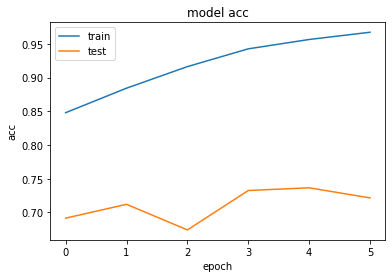

In [ ]:
plt.plot(history_vgg_tuned.history['acc'])
plt.plot(history_vgg_tuned.history['val_acc'])
plt.title('model acc')
plt.ylabel('acc')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

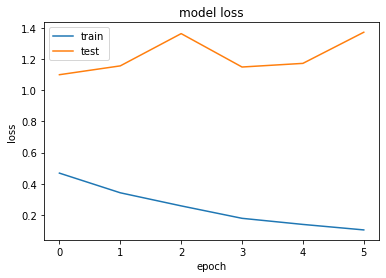

In [ ]:
plt.plot(history_vgg_tuned.history['loss'])
plt.plot(history_vgg_tuned.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [ ]:
#evaluating model accuracy
metrics = model_vgg.evaluate(valid_dataset)
print("model accuracy:",metrics[1])

63/63 [==============================] - 8s 118ms/step - loss: 1.0990 - acc: 0.6915
model accuracy: 0.6915000081062317


We see that our finetuned model seems to overfit the data, and there is no point of convergence between the train and test accuracy. As such, we will likely not be using the finetuned model as our final model.

## EfficientNetB4

We know from online research that EfficientNet models achieve both higher accuracy and better efficiency over existing CNNs. Therefore, we will try to fit our dataset onto EfficientNetB4.

In [ ]:
#importing model and removing top layers
base_b4 = tf.keras.applications.EfficientNetB4(
    include_top=False, weights='imagenet',
    input_shape=(224,224,3), pooling='max', classes=10,
    classifier_activation='softmax'
)

In [ ]:
base_b4.summary()

Model: "efficientnetb4"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
rescaling_2 (Rescaling)         (None, 224, 224, 3)  0           input_3[0][0]                    
__________________________________________________________________________________________________
normalization_1 (Normalization) (None, 224, 224, 3)  7           rescaling_2[0][0]                
__________________________________________________________________________________________________
stem_conv_pad (ZeroPadding2D)   (None, 225, 225, 3)  0           normalization_1[0][0]            
_____________________________________________________________________________________

In [ ]:
# freeze all convolutional VGG16 layers. 
#Freezing reduces training time as the backward passes go down in number.

for layer in base_b4.layers:
    layer.trainable = False

In [ ]:
x = base_b4.output

#removed Global Average Pooling layer as it gave us a dimension error.

#Dense Layer
x = Dense(512, activation='relu')(x)
#Dropout 
x = Dropout(0.3)(x)

# we use softmax here because we are predicting multiple classes
predictions = Dense(num_classes, activation='softmax')(x)


model_b4 = Model(inputs=base_b4.input, outputs=predictions)
len(model_b4.layers)

478

In [ ]:
for layer in model_b4.layers:
    print(layer.name)
    print(layer.trainable)

input_3
False
rescaling_2
False
normalization_1
False
stem_conv_pad
False
stem_conv
False
stem_bn
False
stem_activation
False
block1a_dwconv
False
block1a_bn
False
block1a_activation
False
block1a_se_squeeze
False
block1a_se_reshape
False
block1a_se_reduce
False
block1a_se_expand
False
block1a_se_excite
False
block1a_project_conv
False
block1a_project_bn
False
block1b_dwconv
False
block1b_bn
False
block1b_activation
False
block1b_se_squeeze
False
block1b_se_reshape
False
block1b_se_reduce
False
block1b_se_expand
False
block1b_se_excite
False
block1b_project_conv
False
block1b_project_bn
False
block1b_drop
False
block1b_add
False
block2a_expand_conv
False
block2a_expand_bn
False
block2a_expand_activation
False
block2a_dwconv_pad
False
block2a_dwconv
False
block2a_bn
False
block2a_activation
False
block2a_se_squeeze
False
block2a_se_reshape
False
block2a_se_reduce
False
block2a_se_expand
False
block2a_se_excite
False
block2a_project_conv
False
block2a_project_bn
False
block2b_expand_conv

In [ ]:
#define the hyperparameters, such as learning rate, batch size and epochs
lr_b4 = 0.001
batch_b4 = 32
epochs_b4 = 20

In [ ]:
# creates the optimizer using a tensorFlow optimizer with lr setting the Learning Rate

# tf.keras optimizer
opt = optimizers.Adam(lr_b4)

# compile the model 
model_b4.compile(optimizer= opt, loss='categorical_crossentropy',metrics=['acc'])

In [ ]:
# early stopping if no improvement in val loss after 5 epochs

early_stopping = EarlyStopping(
    monitor = 'val_loss',
    patience=5,
    min_delta=0.001,
    restore_best_weights=True)

In [ ]:
#create model checkpoint to save our model and weights

checkpoint = ModelCheckpoint('./checkpoints/b4_weights_{epoch:02d}_{val_acc:.2f}.hdf5', verbose=1, 
                             save_best_only=True, mode='auto')

In [ ]:
# Train the model 
history_b4 = model_b4.fit( train_dataset,
                   epochs = epochs_b4,
                   validation_data = valid_dataset,
                   callbacks=[early_stopping,checkpoint])

Epoch 1/20
250/250 [==============================] - 53s 160ms/step - loss: 3.1015 - acc: 0.3609 - val_loss: 1.1386 - val_acc: 0.6285

Epoch 00001: val_loss improved from inf to 1.13861, saving model to ./checkpoints/b4_weights_01_0.63.hdf5
Epoch 2/20
250/250 [==============================] - 37s 149ms/step - loss: 1.2205 - acc: 0.5888 - val_loss: 1.0527 - val_acc: 0.6495

Epoch 00002: val_loss improved from 1.13861 to 1.05273, saving model to ./checkpoints/b4_weights_02_0.65.hdf5
Epoch 3/20
250/250 [==============================] - 38s 151ms/step - loss: 1.1038 - acc: 0.6263 - val_loss: 1.0021 - val_acc: 0.6835

Epoch 00003: val_loss improved from 1.05273 to 1.00213, saving model to ./checkpoints/b4_weights_03_0.68.hdf5
Epoch 4/20
250/250 [==============================] - 37s 149ms/step - loss: 1.0347 - acc: 0.6514 - val_loss: 0.9889 - val_acc: 0.6650

Epoch 00004: val_loss improved from 1.00213 to 0.98894, saving model to ./checkpoints/b4_weights_04_0.67.hdf5
Epoch 5/20
250/250 [

Here we see that training with EfficientNetB4 gives us a validation accuracy of around 71%. We may want to explore unfreezing some top layers for finetuning the model, since we froze all 475 layers, except for the last 3 layers we created.

In [ ]:
 #unfreeze layers
 base_b4.trainable = True

#freeze layers before layer 446 (before block 7a)
for layer in base_b4.layers[:446]:
    layer.trainable =  False



In [ ]:
# lower the learning rate to reduce overfit
opt = optimizers.Adam(0.0001)

# compile the model 
model_b4.compile(optimizer= opt, loss='categorical_crossentropy',metrics=['acc'])

In [ ]:
checkpoint = ModelCheckpoint('./checkpoints/b4_tuned_weights_{epoch:02d}_{val_acc:.2f}.hdf5', verbose=1, 
                             save_best_only=True, mode='auto')

In [ ]:
for layer in model_b4.layers:
    print(layer.name)
    print(layer.trainable)

input_3
False
rescaling_2
False
normalization_1
False
stem_conv_pad
False
stem_conv
False
stem_bn
False
stem_activation
False
block1a_dwconv
False
block1a_bn
False
block1a_activation
False
block1a_se_squeeze
False
block1a_se_reshape
False
block1a_se_reduce
False
block1a_se_expand
False
block1a_se_excite
False
block1a_project_conv
False
block1a_project_bn
False
block1b_dwconv
False
block1b_bn
False
block1b_activation
False
block1b_se_squeeze
False
block1b_se_reshape
False
block1b_se_reduce
False
block1b_se_expand
False
block1b_se_excite
False
block1b_project_conv
False
block1b_project_bn
False
block1b_drop
False
block1b_add
False
block2a_expand_conv
False
block2a_expand_bn
False
block2a_expand_activation
False
block2a_dwconv_pad
False
block2a_dwconv
False
block2a_bn
False
block2a_activation
False
block2a_se_squeeze
False
block2a_se_reshape
False
block2a_se_reduce
False
block2a_se_expand
False
block2a_se_excite
False
block2a_project_conv
False
block2a_project_bn
False
block2b_expand_conv

In [ ]:
# Train the model 
history_b4_tuned = model_b4.fit( train_dataset,
                   epochs = epochs_b4,
                   validation_data = valid_dataset,
                   callbacks=[early_stopping,checkpoint])

Epoch 1/20
250/250 [==============================] - 55s 169ms/step - loss: 1.0823 - acc: 0.6436 - val_loss: 0.9503 - val_acc: 0.7175

Epoch 00001: val_loss did not improve from 0.88394
Epoch 2/20
250/250 [==============================] - 38s 151ms/step - loss: 0.6402 - acc: 0.7850 - val_loss: 0.9514 - val_acc: 0.7295

Epoch 00002: val_loss did not improve from 0.88394
Epoch 3/20
250/250 [==============================] - 38s 152ms/step - loss: 0.4405 - acc: 0.8525 - val_loss: 0.9613 - val_acc: 0.7430

Epoch 00003: val_loss did not improve from 0.88394
Epoch 4/20
250/250 [==============================] - 38s 150ms/step - loss: 0.3637 - acc: 0.8777 - val_loss: 1.0062 - val_acc: 0.7405

Epoch 00004: val_loss did not improve from 0.88394
Epoch 5/20
250/250 [==============================] - 37s 150ms/step - loss: 0.2890 - acc: 0.9020 - val_loss: 1.0167 - val_acc: 0.7425

Epoch 00005: val_loss did not improve from 0.88394
Epoch 6/20
250/250 [==============================] - 38s 150ms/s

### EfficientNet B4 evaluation

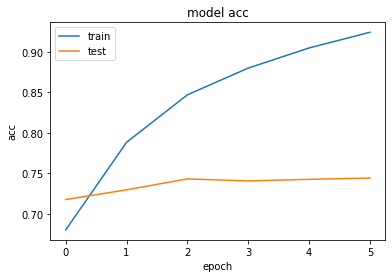

In [ ]:
plt.plot(history_b4_tuned.history['acc'])
plt.plot(history_b4_tuned.history['val_acc'])
plt.title('model acc')
plt.ylabel('acc')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

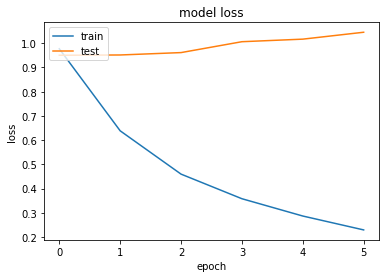

In [ ]:
plt.plot(history_b4_tuned.history['loss'])
plt.plot(history_b4_tuned.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [ ]:
#evaluating model accuracy
metrics = model_b4.evaluate(valid_dataset)
print("model accuracy:",metrics[1])

63/63 [==============================] - 8s 125ms/step - loss: 0.9503 - acc: 0.7175
model accuracy: 0.7174999713897705


We see that even though we unfreezed some top layers of EfficientNetB4 for training and achieved an improvement in validation accuracy from 71% to 74%, the validation loss did not improve, implying that our model likely overfit. As such, we will use the previously untuned EfficientNetB4 as our final model, considering validation loss and validation accuracy.

## Analysing best model

We see that EfficientNetB4 seems like our best model. We will proceed to analyse the model and see how well it generalises to unseen data.

In [ ]:
#loading weights from epoch 13
model_b4.load_weights('./checkpoints/b4_weights_13_0.72.hdf5')

In [ ]:
# predict the validation dataset

preds = model_b4.predict(valid_dataset)
preds = preds.argmax(axis=-1)


preds.shape

(2000,)

In [ ]:
test_labels = val_labels_list[0:2000]

### Confusion Matrix 

We will plot a confusion matrix to look as a prelude to our analysis of misclassified images. This will also allow us to look at how accurately our model predicts the different classes.

In [ ]:
#plotting a confusion matrix to visualise the model predictions

from sklearn.metrics import confusion_matrix
import itertools

cm = confusion_matrix(test_labels,preds)

In [ ]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.RdBu):

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

Normalized confusion matrix
[[0.86  0.07  0.01  0.015 0.02  0.    0.015 0.    0.    0.01 ]
 [0.055 0.705 0.035 0.01  0.07  0.03  0.005 0.005 0.065 0.02 ]
 [0.055 0.065 0.595 0.05  0.11  0.005 0.015 0.065 0.01  0.03 ]
 [0.025 0.03  0.025 0.62  0.085 0.02  0.015 0.02  0.095 0.065]
 [0.015 0.02  0.04  0.03  0.76  0.005 0.025 0.05  0.02  0.035]
 [0.01  0.06  0.    0.035 0.03  0.8   0.015 0.01  0.025 0.015]
 [0.01  0.005 0.01  0.01  0.065 0.    0.85  0.025 0.02  0.005]
 [0.005 0.    0.06  0.02  0.065 0.    0.06  0.72  0.05  0.02 ]
 [0.01  0.075 0.015 0.055 0.03  0.01  0.04  0.02  0.72  0.025]
 [0.01  0.05  0.05  0.05  0.14  0.035 0.015 0.05  0.015 0.585]]


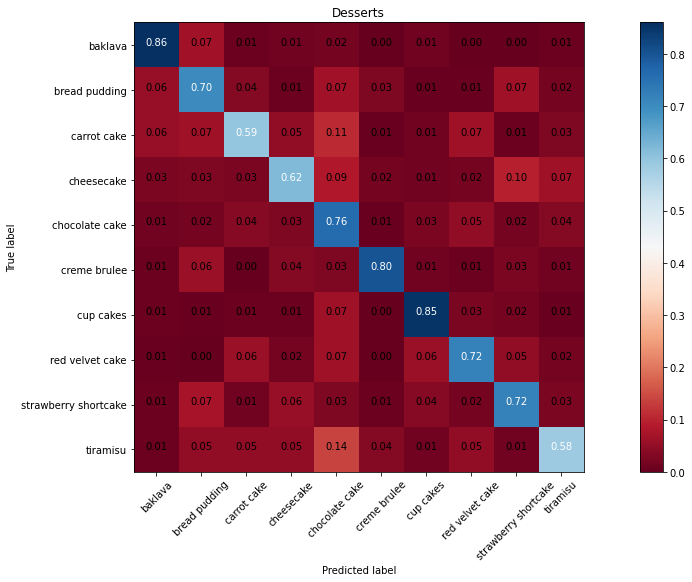

In [ ]:
cm_plot_labels = desserts

# Plot normalized confusion matrix
plt.figure(figsize=(16,8))
plot_confusion_matrix(cm, cm_plot_labels, normalize=True,
                      title='Desserts')
plt.show()

From the confusion matrix, we see that it can predict most classes reasonably well, with the exception of tiramisu and carrot cake. We also see that tiramisu is most often misclassified as chocolate cake and carrot cake is most often misclassified as chocolate cake. This seems to be quite a reasonable misclassification. We will now drill down deeper into the model and look at what types of images are mostly misclassified.

### Further analysis on misclassified images

In [ ]:
# add predicted labels to validation dataframe we created earlier
df_val['predicted'] = preds

df_val.head()

Unnamed: 0  ... misclassified
0           0  ...          True
1           1  ...          True
2           2  ...          True
3           3  ...          True
4           4  ...          True

[5 rows x 5 columns]

In [ ]:
# create missclassified column

df_val['misclassified'] =  np.where(df_val['class'] == df_val['predicted'], True, False)

df_val.head()

Unnamed: 0  ... misclassified
0           0  ...         False
1           1  ...          True
2           2  ...          True
3           3  ...          True
4           4  ...         False

[5 rows x 5 columns]

In [ ]:
df_val.drop(columns='Unnamed: 0', inplace=True)

In [ ]:
#show misclassified images

df_val[df_val['misclassified']== False]

path  ...  misclassified
0     /content/gdrive/MyDrive/capstone_project/datas...  ...          False
4     /content/gdrive/MyDrive/capstone_project/datas...  ...          False
6     /content/gdrive/MyDrive/capstone_project/datas...  ...          False
8     /content/gdrive/MyDrive/capstone_project/datas...  ...          False
9     /content/gdrive/MyDrive/capstone_project/datas...  ...          False
...                                                 ...  ...            ...
1988  /content/gdrive/MyDrive/capstone_project/datas...  ...          False
1994  /content/gdrive/MyDrive/capstone_project/datas...  ...          False
1995  /content/gdrive/MyDrive/capstone_project/datas...  ...          False
1996  /content/gdrive/MyDrive/capstone_project/datas...  ...          False
1997  /content/gdrive/MyDrive/capstone_project/datas...  ...          False

[557 rows x 4 columns]

We have a total of 557 misclassified images.

In [ ]:
df_val.groupby('class')['misclassified'].value_counts()

class  misclassified
0      True             172
       False             28
1      True             141
       False             59
2      True             119
       False             81
3      True             124
       False             76
4      True             152
       False             48
5      True             160
       False             40
6      True             170
       False             30
7      True             144
       False             56
8      True             144
       False             56
9      True             117
       False             83
Name: misclassified, dtype: int64

We can see that tiramisu (class 9) gets misclassified most often, followed by carrot cake and cheese cake.

In [ ]:
desserts

['baklava',
 'bread pudding',
 'carrot cake',
 'cheesecake',
 'chocolate cake',
 'creme brulee',
 'cup cakes',
 'red velvet cake',
 'strawberry shortcake',
 'tiramisu']

In [ ]:
#visualising misclassified images

df_val['labels'] = df_val['class'].map( {0: 'baklava', 1: 'bread pudding', 2: 'carrot cake',
                                         3: 'cheesecake', 4: 'chocolate cake', 5: 'creme brulee',
                                         6: 'cup cakes', 7: 'red velvet cake', 8: 'strawberry shortcake',
                                         9: 'tiramisu'
                                         }
    
)

df_val.head()

path  ...                labels
0  /content/gdrive/MyDrive/capstone_project/datas...  ...          creme brulee
1  /content/gdrive/MyDrive/capstone_project/datas...  ...            cheesecake
2  /content/gdrive/MyDrive/capstone_project/datas...  ...               baklava
3  /content/gdrive/MyDrive/capstone_project/datas...  ...  strawberry shortcake
4  /content/gdrive/MyDrive/capstone_project/datas...  ...            cheesecake

[5 rows x 5 columns]

In [ ]:
misclass_df = df_val[df_val['misclassified']==False]
misclass_df.head()

path  ...        labels
0  /content/gdrive/MyDrive/capstone_project/datas...  ...  creme brulee
4  /content/gdrive/MyDrive/capstone_project/datas...  ...    cheesecake
6  /content/gdrive/MyDrive/capstone_project/datas...  ...       baklava
8  /content/gdrive/MyDrive/capstone_project/datas...  ...      tiramisu
9  /content/gdrive/MyDrive/capstone_project/datas...  ...    cheesecake

[5 rows x 5 columns]

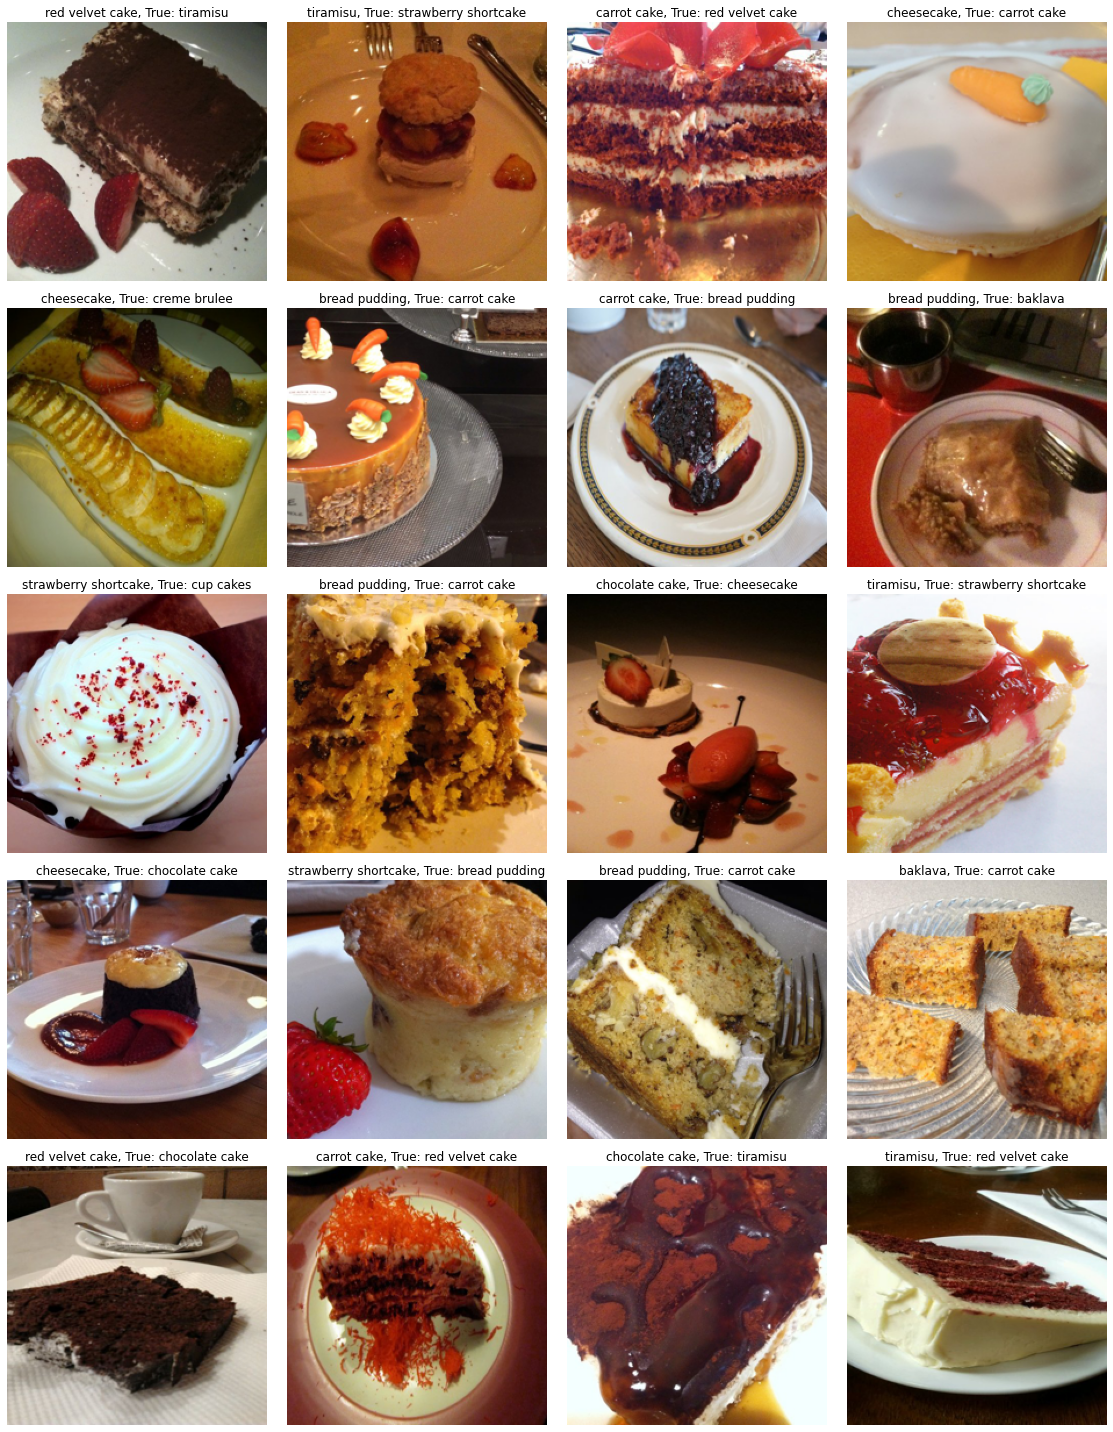

In [ ]:
import PIL.Image

plt.figure(figsize=(16, 20))

for i, j in zip(range(20), random.sample(set(misclass_df.index), 20)):
    
    ax = plt.subplot(5, 4, i + 1)
    
    image_dir = misclass_df['path'][j]

    image = PIL.Image.open(image_dir).resize((224, 224))
    prediction = misclass_df['predicted'][j]
    dessert_label = misclass_df['labels'][j]
    
    plt.imshow(image)
    plt.title(desserts[prediction]+ ', True: ' + dessert_label)
    plt.axis("off")
    plt.tight_layout()

We see from some of the misclassified images that the misclassification seems reasonable. Due to the colour of tiramisu being similar to chocolate cake, it could sometimes be misclassified as such. The lighting of some of the images and coverings/sauces on food seems to also cause our model to misclassify the food classes.

## Testing our model on unseen data

We have seen the misclassified images and deemed them to be reasonable misclassifications. We will now test our model to see how well it generalises against unseen data. For this we have downloaded some images from google and unsplash to see if our best model correctly predicts the different classes.

### Predicting tiramisu

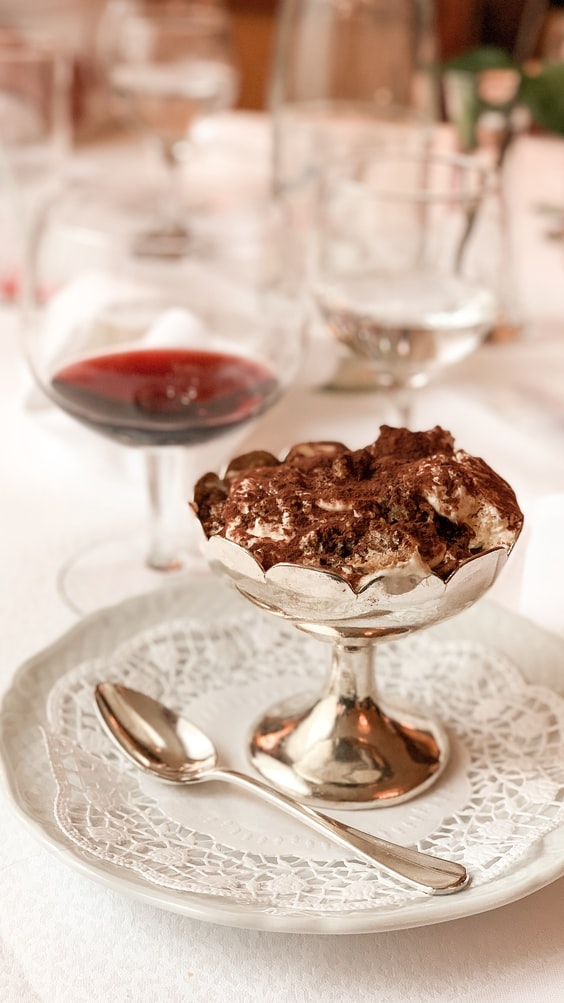

In [ ]:
#downloaded picture from unsplash
from IPython.display import Image

image_name = 'tiramisu.jpg'
Image(image_name)

In [ ]:
from keras.applications.imagenet_utils import preprocess_input, decode_predictions

#preprocessing image to resize it into dimension of 224 by 224, then converting image into an array
img = tf.keras.preprocessing.image.load_img(image_name, target_size=(224, 224))
x = tf.keras.preprocessing.image.img_to_array(img)
x = np.expand_dims(x, axis=0)
# x = preprocess_input(x)
print('Input image shape:', x.shape)

Input image shape: (1, 224, 224, 3)


In [ ]:
#make predictions

pred = model_b4.predict(x)
print('Predicted:', pred)

#we use highest values from our predictions
print(np.argmax(pred))

Predicted: [[1.1445968e-03 1.1208255e-03 1.0981462e-02 7.5831292e-03 7.6299654e-03
  6.4992034e-03 5.7384541e-04 7.7667972e-03 8.1194649e-03 9.4858074e-01]]
9


In [ ]:
result= np.argmax(pred)
if result==0:
    print("baklava")
elif result==1:
    print("bread pudding")
elif result==2:
    print("carrot cake")
elif result==3:
    print("cheesecake")
elif result==4:
    print("chocolate cake")
elif result==5:
    print("creme brulee")
elif result==6:
    print("cup cakes")
elif result==7:
    print("red velvet cake")
elif result==8:
    print("strawberry shortcake")
elif result==9:
    print("tiramisu")

tiramisu


### Predicting creme brulee

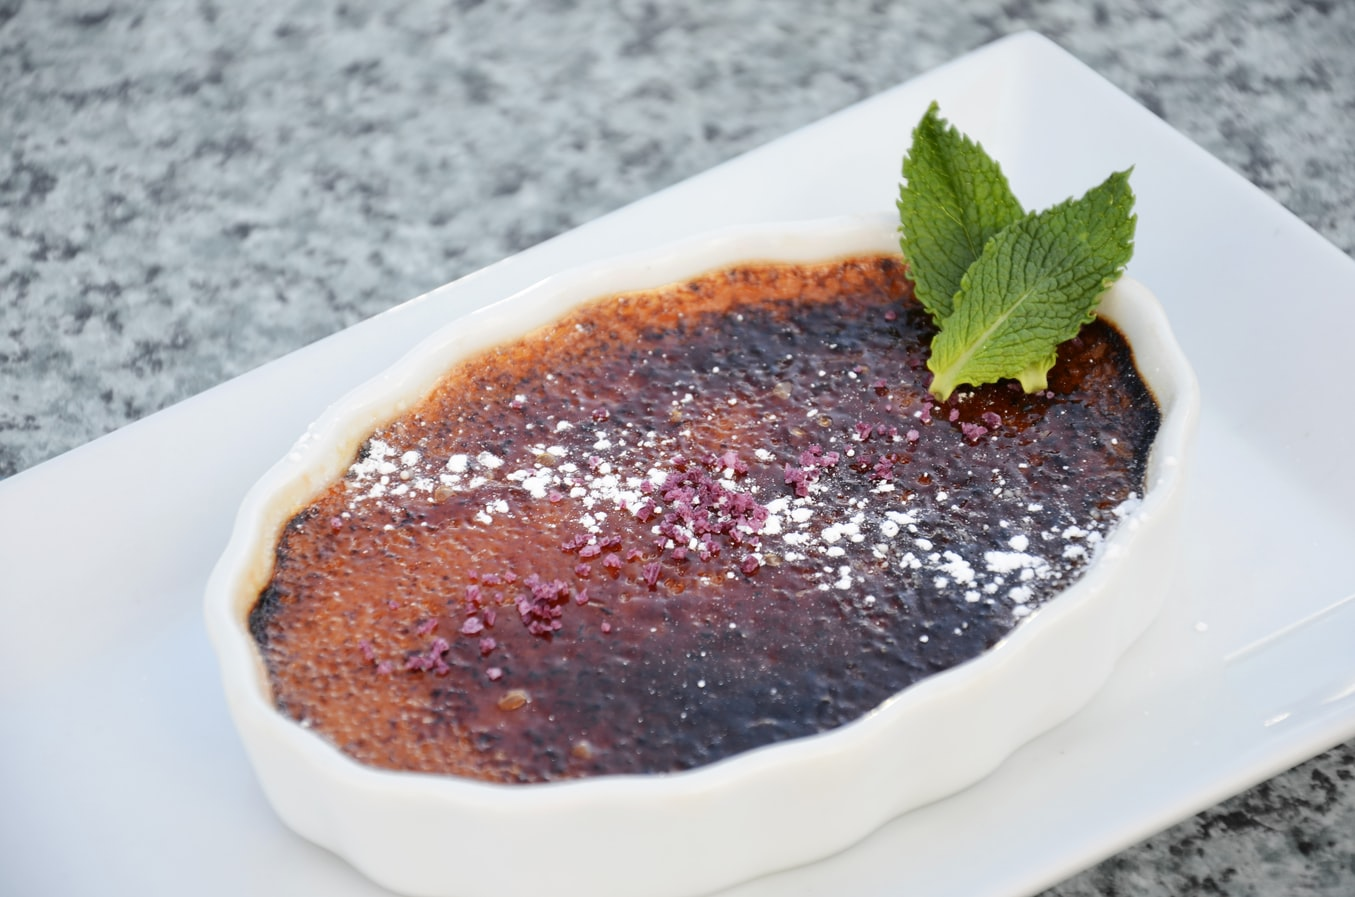

In [ ]:
image2_name = 'creme.jpg'
Image(image2_name)

In [ ]:
#preprocessing image to resize it into dimension of 224 by 224, then converting image into an array
img = tf.keras.preprocessing.image.load_img(image2_name, target_size=(224, 224))
x = tf.keras.preprocessing.image.img_to_array(img)
x = np.expand_dims(x, axis=0)
# x = preprocess_input(x)
print('Input image shape:', x.shape)

Input image shape: (1, 224, 224, 3)


In [ ]:
#make predictions

pred = model_b4.predict(x)
print('Predicted:', pred)

#we use highest values from our predictions
print(np.argmax(pred))

Predicted: [[3.5283675e-03 1.9167593e-01 7.2435592e-03 3.2843426e-02 1.0243345e-01
  6.2013549e-01 2.4463265e-04 7.2141597e-04 2.1550190e-03 3.9018683e-02]]
5


In [ ]:
result= np.argmax(pred)
if result==0:
    print("baklava")
elif result==1:
    print("bread pudding")
elif result==2:
    print("carrot cake")
elif result==3:
    print("cheesecake")
elif result==4:
    print("chocolate cake")
elif result==5:
    print("creme brulee")
elif result==6:
    print("cup cakes")
elif result==7:
    print("red velvet cake")
elif result==8:
    print("strawberry shortcake")
elif result==9:
    print("tiramisu")

creme brulee


### Predicting cupcakes

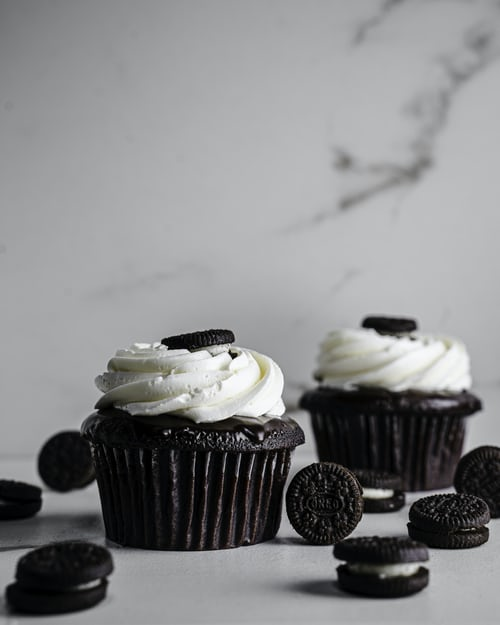

In [ ]:
image3_name = 'cup.jpg'
Image(image3_name)

In [ ]:
#preprocessing image to resize it into dimension of 224 by 224, then converting image into an array
img = tf.keras.preprocessing.image.load_img(image3_name, target_size=(224, 224))
x = tf.keras.preprocessing.image.img_to_array(img)
x = np.expand_dims(x, axis=0)
# x = preprocess_input(x)
print('Input image shape:', x.shape)

Input image shape: (1, 224, 224, 3)


In [ ]:
#make predictions

pred = model_b4.predict(x)
print('Predicted:', pred)

#we use highest values from our predictions
print(np.argmax(pred))

Predicted: [[5.1614234e-07 1.6578235e-05 1.6968019e-04 1.8657889e-03 1.8606137e-04
  1.4387302e-05 9.9654007e-01 8.6669083e-04 2.5038442e-04 8.9902816e-05]]
6


In [ ]:
result= np.argmax(pred)
if result==0:
    print("baklava")
elif result==1:
    print("bread pudding")
elif result==2:
    print("carrot cake")
elif result==3:
    print("cheesecake")
elif result==4:
    print("chocolate cake")
elif result==5:
    print("creme brulee")
elif result==6:
    print("cup cakes")
elif result==7:
    print("red velvet cake")
elif result==8:
    print("strawberry shortcake")
elif result==9:
    print("tiramisu")

cup cakes


### Predicting chocolate cake

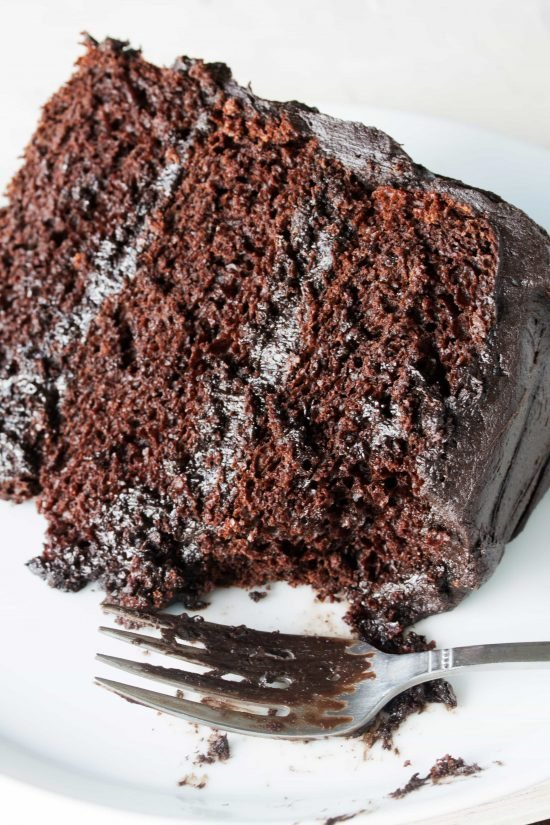

In [ ]:
image4_name = 'choccy.jpg'
Image(image4_name)

In [ ]:
#preprocessing image to resize it into dimension of 224 by 224, then converting image into an array
img = tf.keras.preprocessing.image.load_img(image4_name, target_size=(224, 224))
x = tf.keras.preprocessing.image.img_to_array(img)
x = np.expand_dims(x, axis=0)
# x = preprocess_input(x)
print('Input image shape:', x.shape)

Input image shape: (1, 224, 224, 3)


In [ ]:
#make predictions

pred = model_b4.predict(x)
print('Predicted:', pred)

#we use highest values from our predictions
print(np.argmax(pred))

Predicted: [[6.26641704e-05 3.39918857e-04 1.37374885e-02 9.52221546e-03
  7.97116220e-01 4.31907779e-07 3.97440628e-04 1.16004504e-01
  1.01036465e-04 6.27179742e-02]]
4


In [ ]:
result= np.argmax(pred)
if result==0:
    print("baklava")
elif result==1:
    print("bread pudding")
elif result==2:
    print("carrot cake")
elif result==3:
    print("cheesecake")
elif result==4:
    print("chocolate cake")
elif result==5:
    print("creme brulee")
elif result==6:
    print("cup cakes")
elif result==7:
    print("red velvet cake")
elif result==8:
    print("strawberry shortcake")
elif result==9:
    print("tiramisu")

chocolate cake


### Predicting strawberry shortcake

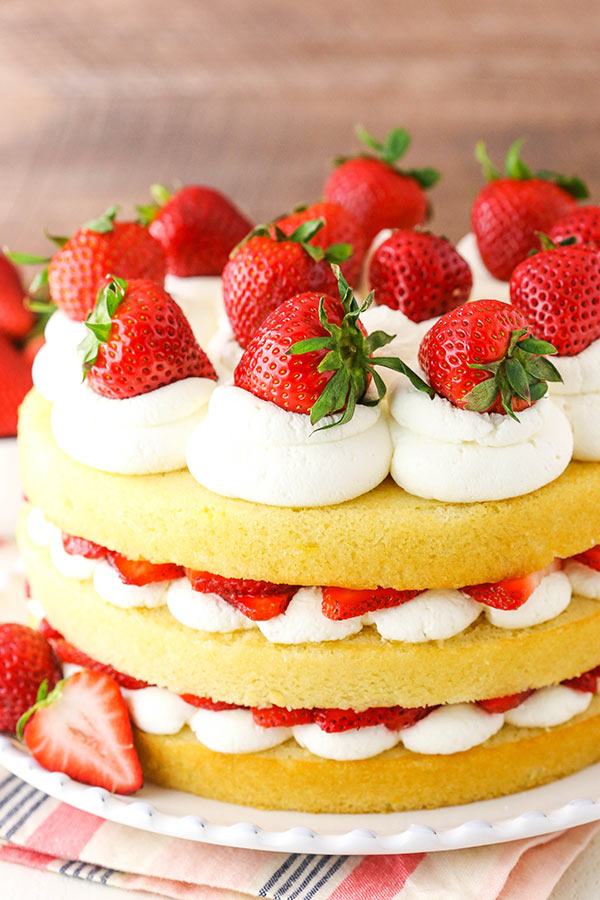

In [ ]:
image5_name = 'ssc.jpg'
Image(image5_name)

In [ ]:
#preprocessing image to resize it into dimension of 224 by 224, then converting image into an array
img = tf.keras.preprocessing.image.load_img(image5_name, target_size=(224, 224))
x = tf.keras.preprocessing.image.img_to_array(img)
x = np.expand_dims(x, axis=0)
# x = preprocess_input(x)
print('Input image shape:', x.shape)

Input image shape: (1, 224, 224, 3)


In [ ]:
#make predictions

pred = model_b4.predict(x)
print('Predicted:', pred)

#we use highest values from our predictions
print(np.argmax(pred))

Predicted: [[4.07827315e-07 1.90980762e-04 5.69036871e-04 1.49107352e-02
  1.51912434e-04 1.07379150e-04 1.48309977e-03 1.04287425e-02
  9.72055972e-01 1.01760954e-04]]
8


In [ ]:
result= np.argmax(pred)
if result==0:
    print("baklava")
elif result==1:
    print("bread pudding")
elif result==2:
    print("carrot cake")
elif result==3:
    print("cheesecake")
elif result==4:
    print("chocolate cake")
elif result==5:
    print("creme brulee")
elif result==6:
    print("cup cakes")
elif result==7:
    print("red velvet cake")
elif result==8:
    print("strawberry shortcake")
elif result==9:
    print("tiramisu")

strawberry shortcake


### Predicting baklava

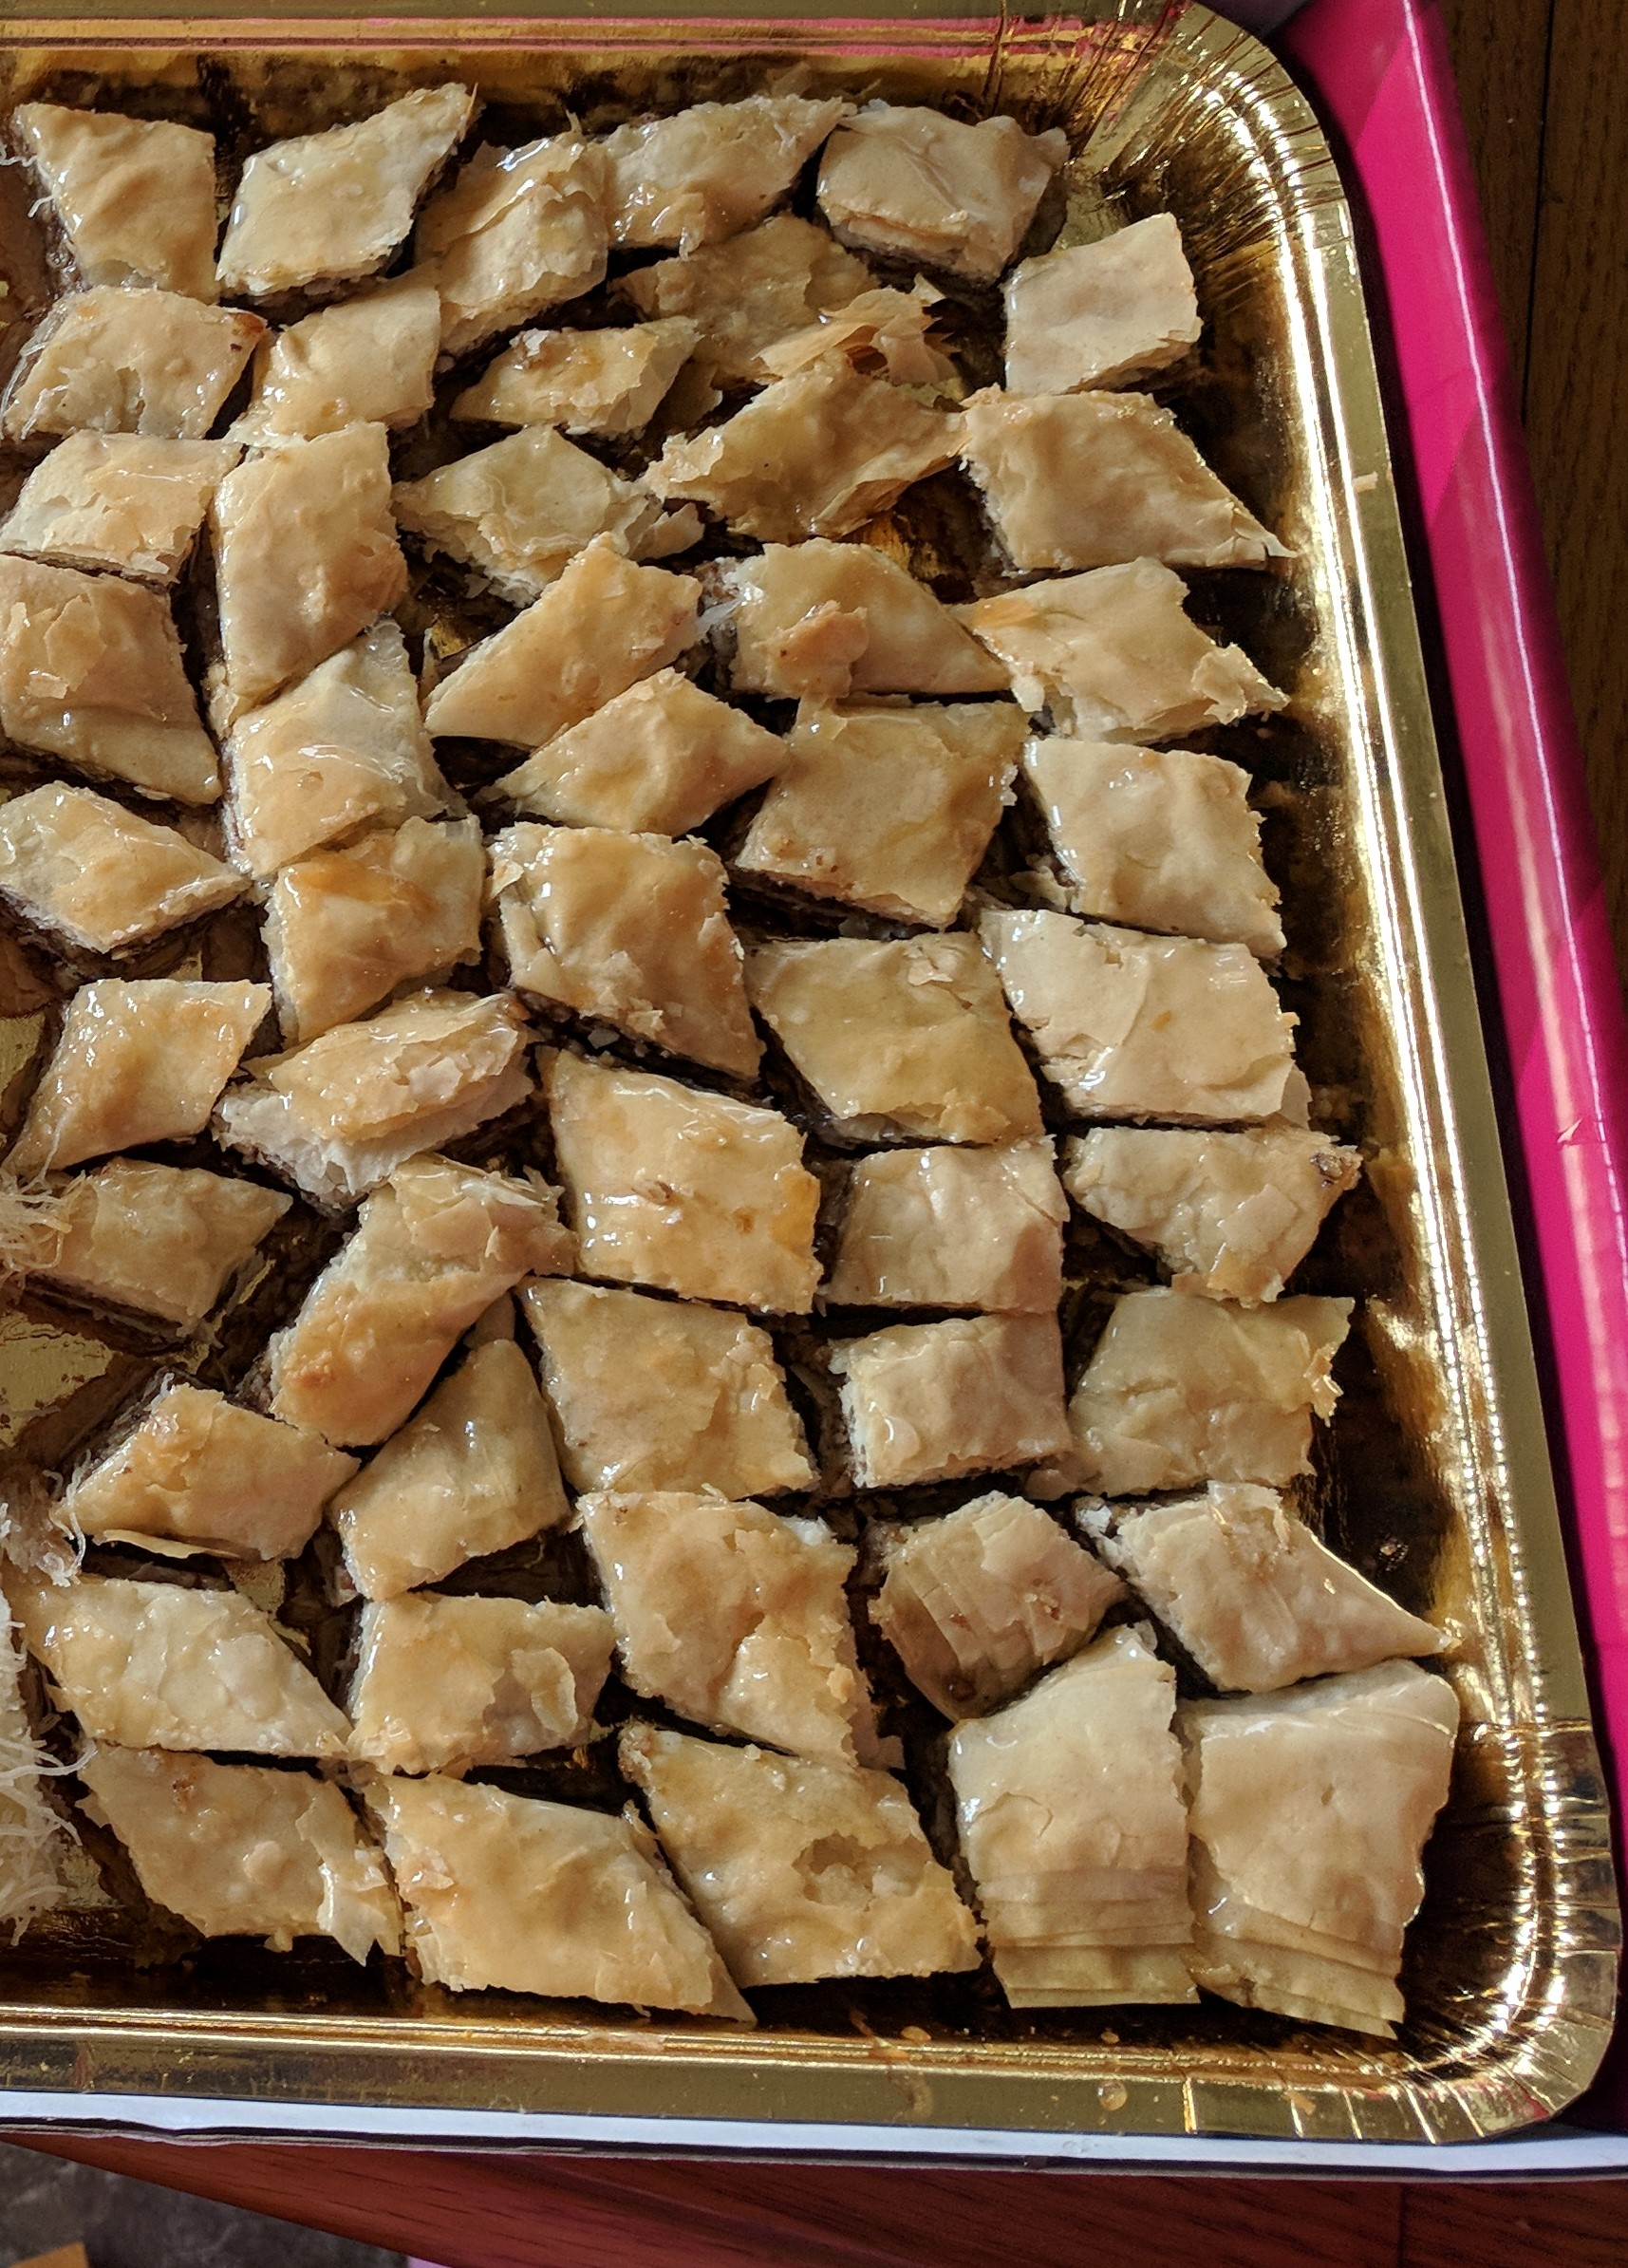

In [ ]:
image6_name = 'bakl.jpg'
Image(image6_name)

In [ ]:
#preprocessing image to resize it into dimension of 224 by 224, then converting image into an array
img = tf.keras.preprocessing.image.load_img(image6_name, target_size=(224, 224))
x = tf.keras.preprocessing.image.img_to_array(img)
x = np.expand_dims(x, axis=0)
# x = preprocess_input(x)
print('Input image shape:', x.shape)

Input image shape: (1, 224, 224, 3)


In [ ]:
#make predictions

pred = model_b4.predict(x)
print('Predicted:', pred)

#we use highest values from our predictions
print(np.argmax(pred))

Predicted: [[0.7599108  0.05712918 0.04460429 0.01245337 0.01938806 0.05238985
  0.00243545 0.00160633 0.00359477 0.04648785]]
0


In [ ]:
result= np.argmax(pred)
if result==0:
    print("baklava")
elif result==1:
    print("bread pudding")
elif result==2:
    print("carrot cake")
elif result==3:
    print("cheesecake")
elif result==4:
    print("chocolate cake")
elif result==5:
    print("creme brulee")
elif result==6:
    print("cup cakes")
elif result==7:
    print("red velvet cake")
elif result==8:
    print("strawberry shortcake")
elif result==9:
    print("tiramisu")

baklava


### Predicting bread pudding

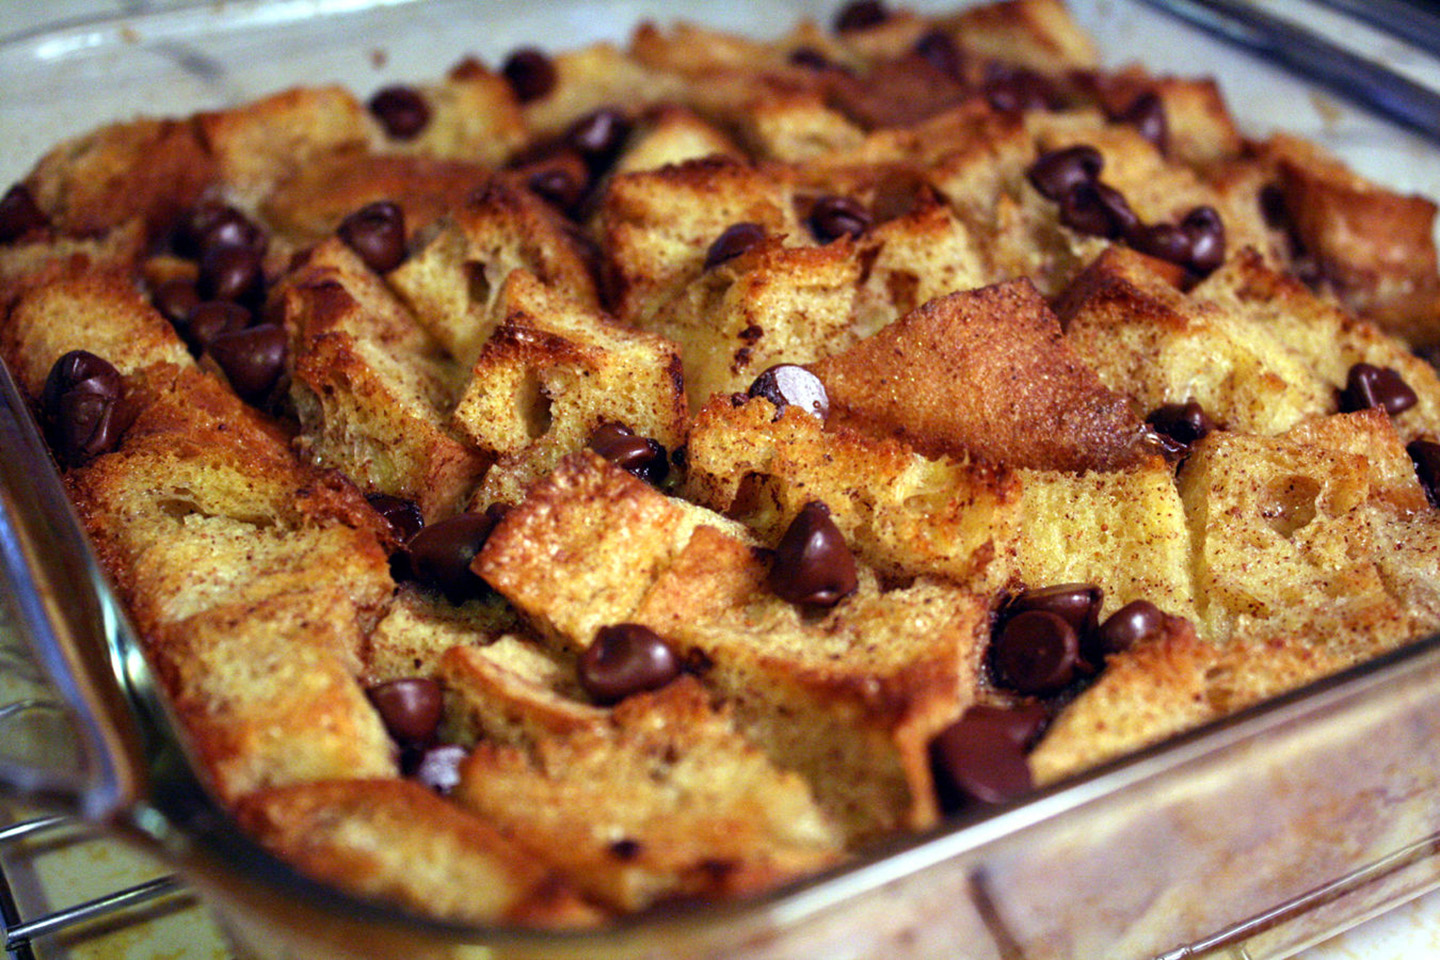

In [ ]:
image7_name = 'bpud.jpg'
Image(image7_name)

In [ ]:
#preprocessing image to resize it into dimension of 224 by 224, then converting image into an array
img = tf.keras.preprocessing.image.load_img(image7_name, target_size=(224, 224))
x = tf.keras.preprocessing.image.img_to_array(img)
x = np.expand_dims(x, axis=0)
# x = preprocess_input(x)
print('Input image shape:', x.shape)

Input image shape: (1, 224, 224, 3)


In [ ]:
#make predictions

pred = model_b4.predict(x)
print('Predicted:', pred)

#we use highest values from our predictions
print(np.argmax(pred))

Predicted: [[1.8990409e-01 6.2779880e-01 3.9249774e-02 5.7130411e-02 2.2724459e-02
  1.8664287e-02 4.9158750e-04 4.7276134e-04 1.8395429e-03 4.1724339e-02]]
1


In [ ]:
result= np.argmax(pred)
if result==0:
    print("baklava")
elif result==1:
    print("bread pudding")
elif result==2:
    print("carrot cake")
elif result==3:
    print("cheesecake")
elif result==4:
    print("chocolate cake")
elif result==5:
    print("creme brulee")
elif result==6:
    print("cup cakes")
elif result==7:
    print("red velvet cake")
elif result==8:
    print("strawberry shortcake")
elif result==9:
    print("tiramisu")

bread pudding


### Predicting carrot cake

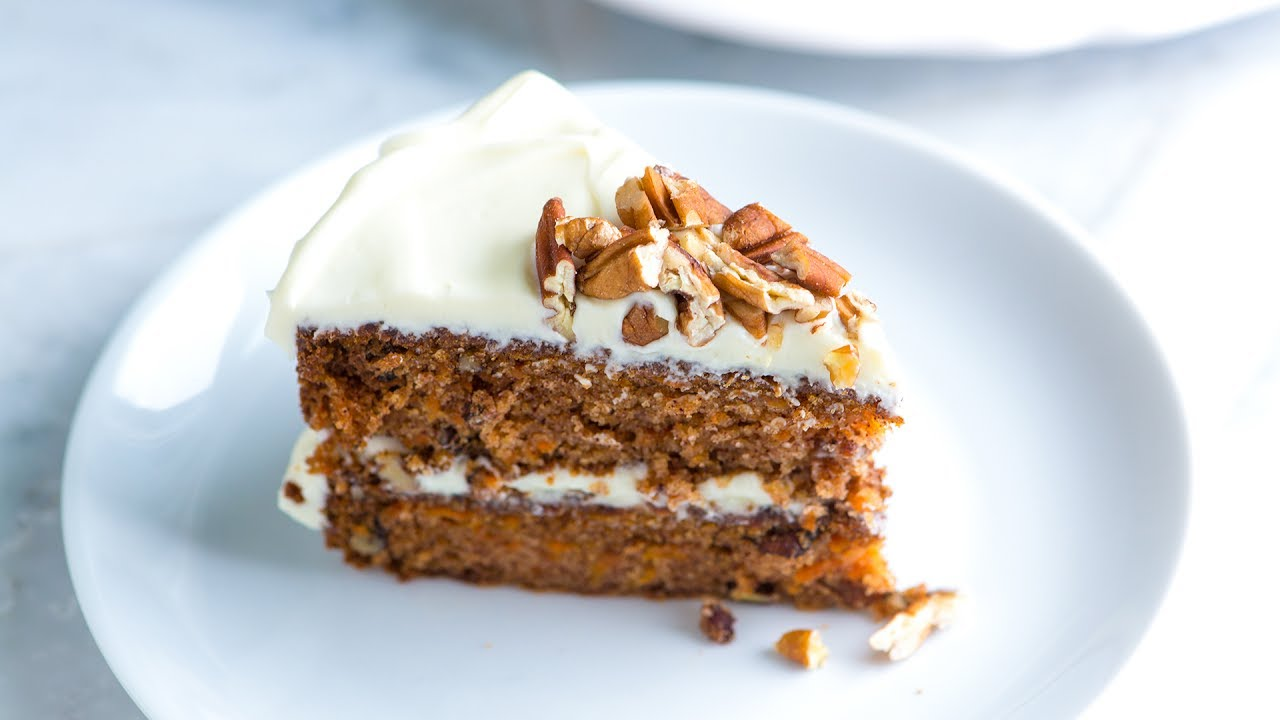

In [ ]:
image8_name = 'ccake.jpg'
Image(image8_name)

In [ ]:
#preprocessing image to resize it into dimension of 224 by 224, then converting image into an array
img = tf.keras.preprocessing.image.load_img(image8_name, target_size=(224, 224))
x = tf.keras.preprocessing.image.img_to_array(img)
x = np.expand_dims(x, axis=0)
# x = preprocess_input(x)
print('Input image shape:', x.shape)

Input image shape: (1, 224, 224, 3)


In [ ]:
#make predictions

pred = model_b4.predict(x)
print('Predicted:', pred)

#we use highest values from our predictions
print(np.argmax(pred))

Predicted: [[1.1901150e-06 1.3927485e-08 9.9906749e-01 6.8431444e-07 8.9508650e-04
  1.0552518e-11 2.8769223e-10 2.6935346e-05 4.9014671e-11 8.5214797e-06]]
2


In [ ]:
result= np.argmax(pred)
if result==0:
    print("baklava")
elif result==1:
    print("bread pudding")
elif result==2:
    print("carrot cake")
elif result==3:
    print("cheesecake")
elif result==4:
    print("chocolate cake")
elif result==5:
    print("creme brulee")
elif result==6:
    print("cup cakes")
elif result==7:
    print("red velvet cake")
elif result==8:
    print("strawberry shortcake")
elif result==9:
    print("tiramisu")

carrot cake


### Predicting cheesecake

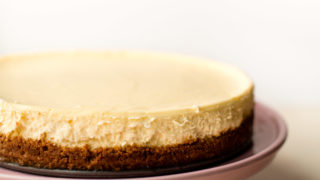

In [ ]:
image9_name = 'chcake.jpg'
Image(image9_name)

In [ ]:
#preprocessing image to resize it into dimension of 224 by 224, then converting image into an array
img = tf.keras.preprocessing.image.load_img(image8_name, target_size=(224, 224))
x = tf.keras.preprocessing.image.img_to_array(img)
x = np.expand_dims(x, axis=0)
# x = preprocess_input(x)
print('Input image shape:', x.shape)

Input image shape: (1, 224, 224, 3)


In [ ]:
#make predictions

pred = model_b4.predict(x)
print('Predicted:', pred)

#we use highest values from our predictions
print(np.argmax(pred))

Predicted: [[1.1901150e-06 1.3927485e-08 9.9906749e-01 6.8431444e-07 8.9508650e-04
  1.0552518e-11 2.8769223e-10 2.6935346e-05 4.9014671e-11 8.5214797e-06]]
2


In [ ]:
result= np.argmax(pred)
if result==0:
    print("baklava")
elif result==1:
    print("bread pudding")
elif result==2:
    print("carrot cake")
elif result==3:
    print("cheesecake")
elif result==4:
    print("chocolate cake")
elif result==5:
    print("creme brulee")
elif result==6:
    print("cup cakes")
elif result==7:
    print("red velvet cake")
elif result==8:
    print("strawberry shortcake")
elif result==9:
    print("tiramisu")

carrot cake


Here we see that our model has misclassified cheesecake as carrot cake. This seems reasonable as the colours of cheesecake in this picture look similar to that of carrot cake.

### Predicting red velvet cake

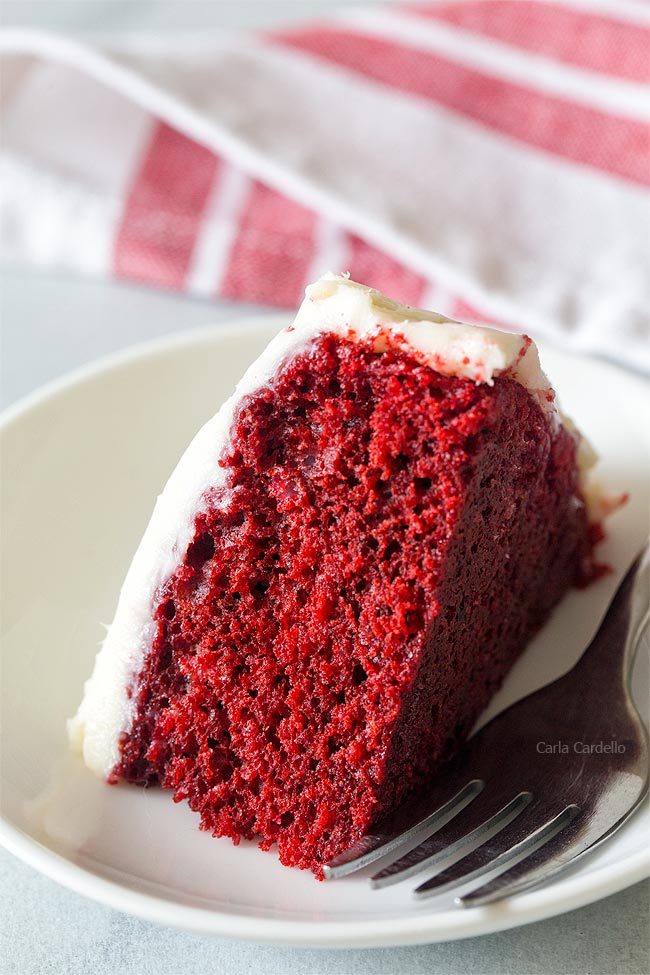

In [ ]:
image10_name = 'rvcake.jpg'
Image(image10_name)

In [ ]:
#preprocessing image to resize it into dimension of 224 by 224, then converting image into an array
img = tf.keras.preprocessing.image.load_img(image10_name, target_size=(224, 224))
x = tf.keras.preprocessing.image.img_to_array(img)
x = np.expand_dims(x, axis=0)
# x = preprocess_input(x)
print('Input image shape:', x.shape)

Input image shape: (1, 224, 224, 3)


In [ ]:
#make predictions

pred = model_b4.predict(x)
print('Predicted:', pred)

#we use highest values from our predictions
print(np.argmax(pred))

Predicted: [[8.8458785e-10 5.6530165e-08 9.3335466e-04 1.1950437e-03 1.2116984e-02
  1.3960499e-08 5.0594095e-05 9.8417193e-01 1.9369653e-04 1.3384594e-03]]
7


In [ ]:
result= np.argmax(pred)
if result==0:
    print("baklava")
elif result==1:
    print("bread pudding")
elif result==2:
    print("carrot cake")
elif result==3:
    print("cheesecake")
elif result==4:
    print("chocolate cake")
elif result==5:
    print("creme brulee")
elif result==6:
    print("cup cakes")
elif result==7:
    print("red velvet cake")
elif result==8:
    print("strawberry shortcake")
elif result==9:
    print("tiramisu")

red velvet cake


This is not an exhaustive test, but from our limited testing, we conclude that our model can generalise well to most classes, but does misclassify certain categories. More training might be needed for it to better distinguish classes like carrot cake from cheesecake. However, overall our model seems to be able to generalise unseen data well, correctly predicting 9 out of 10 classes.

## Saving best model and weights

In [ ]:
#saving model and weights

model_b4.save('dessert_10_classes_final.h5')
model_b4.save_weights('dessert_10_classes_weights_final.h5', save_format='h5')

## Conclusions
To address our problem statement, we have built a 5 class Japanese Food classifier with validation accuracy of around 88% and a 10 class desserts classifier with a validation accuracy rate of around 71%. There is definitely room for improvement, as our model still tends to misclassify some categories, such as predicting cheesecake as carrot cake.


### Room for improvement
If we were to deploy such a solution to production and eventually for usage in unmanned retail and fnb stores, more work will need to be done, in terms of the following: <br>
1) Training the model with more data of the food at different camera angles and heights <br>
2) Training the model with more classes if we have more computational power and time<br>
3) Tuning the model for better accuracy by varying the layers to freeze during training, and use other techniques such as image augmentation or CutMix.